In [1]:
import numpy as np
import matplotlib.pyplot as plt
import filters
import utils
import scipy.io

In [2]:
def dB20(x):
    return 20*np.log(np.abs(x))

def derivate(x):
    y = np.zeros_like(x)
    y[1:] = x[1:]-x[:-1]
    return y

def integrate(x):
    y = x.copy()
    y_prev=0
    for idx in range(0,len(y)):
        y_prev=y[idx]+y_prev
        y[idx]=y_prev
    return y

def get_groupDelay(x_fft, df):
    phase = np.unwrap(np.angle(x_fft.copy()))
    gd=-derivate(phase)
    gd/=df
    return gd

def get_phase(gd, df):
    phase = -integrate(gd)
    phase *= df
    return phase


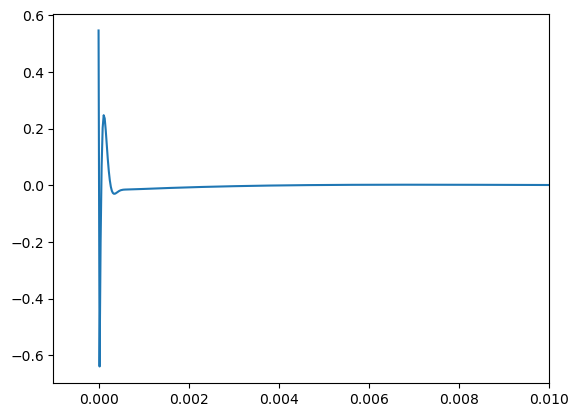

C:\Users\pelad\AppData\Local\Temp\ipykernel_25640\4291461618.py:2: RuntimeWarning: divide by zero encountered in log
  return 20*np.log(np.abs(x))


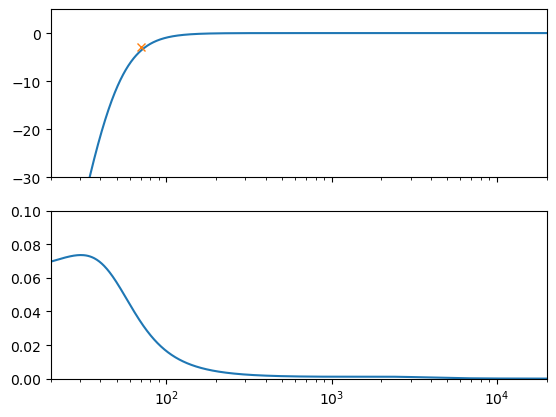

3245.089196907298


In [13]:
sr = 44100
n_fft = 8192*16
Q=.71


f = np.fft.rfftfreq(n=n_fft, d=1/sr)
df = f[1]-f[0]

apf = filters.Parallel(
    filters.LR.LP4(f0=3000, sr=sr),
    filters.LR.HP4(f0=3000, sr=sr),
    sr=44100,
)
#apf = filters.equalizer.RBJ.AllPass(f0=3000, Q=.71, sr=sr)

#hpf = filters.butterworth.HP4(f0=50, sr=sr)
hpf = filters.LR.HP4(f0=47, sr=sr)
#hpf = filters.equalizer.RBJ.HighPass(f0=70, Q=.71, sr=sr)
lpf = filters.butterworth.LP2(f0=20000, sr=sr)

loudspeaker = filters.Series(apf, hpf, sr=sr)
#loudspeaker=hpf
t = np.arange(n_fft)/sr
plt.plot(t, loudspeaker.get_impulseResponse(n=n_fft))
plt.xlim(-0.001, 0.01)
plt.show()

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(f, dB20(loudspeaker.get_rfft(n=n_fft)))
ax[0].plot([70], [-3],'x')
ax[0].set_ylim(-30, 5)
ax[1].plot(f, get_groupDelay(loudspeaker.get_rfft(n=n_fft), df=df))
ax[1].set_ylim(0, .1)
ax[0].set_xlim(20, 20000)
plt.semilogx()
plt.show()

print(sr*np.amax(get_groupDelay(loudspeaker.get_rfft(n=n_fft), df=df)))

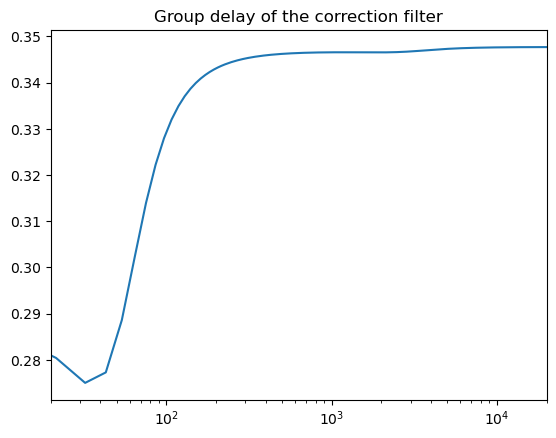

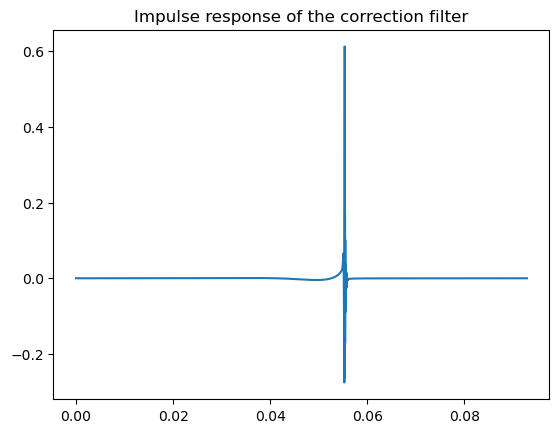

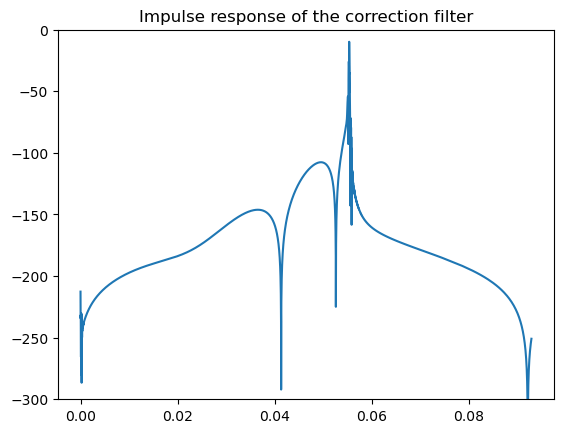

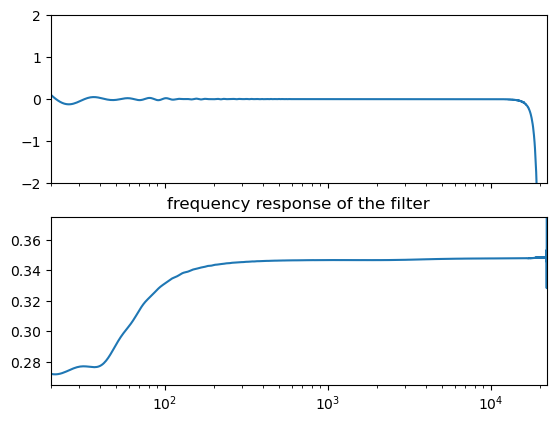

In [51]:
n=4096
cornerFreq_hz = 20
offset =.275
cornerFreq = cornerFreq_hz/sr
cornerFreq_idx = int(n*cornerFreq/2)
f = np.fft.rfftfreq(n=n, d=1/sr)
df = f[1]-f[0]


loudspeakerGroupDelay = get_groupDelay(loudspeaker.get_rfft(n=n), df=df)

correctionGroupDelay = np.zeros_like(loudspeakerGroupDelay)
correctionGroupDelay[cornerFreq_idx:] = -loudspeakerGroupDelay[cornerFreq_idx:]
correctionGroupDelay[:cornerFreq_idx] = -loudspeakerGroupDelay[cornerFreq_idx]
correctionGroupDelay -=np.min(correctionGroupDelay)
correctionGroupDelay +=offset

plt.title('Group delay of the correction filter')

plt.plot(f,correctionGroupDelay)
plt.semilogx()
plt.xlim(20, 20000)
plt.show()
correctionPhase = get_phase(correctionGroupDelay, df=df)

correction_fft = np.exp(1j*correctionPhase)
#correction_fft[0]=0

#corr[:cornerFreq_idx]
corr_IR = np.fft.irfft(correction_fft)

lpf = filters.equalizer.RBJ.LowPass(f0=20000,Q=.71, sr=sr)
corr_IR = lpf.process(corr_IR)



t = np.arange(len(corr_IR))/sr
plt.title('Impulse response of the correction filter')
plt.plot(t, corr_IR)
plt.show()
plt.title('Impulse response of the correction filter')
plt.plot(t, dB20(corr_IR))
plt.ylim(-300, 0)
plt.show()
f = np.fft.rfftfreq(n=n_fft, d=1/sr)
df = f[1]-f[0]

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
plt.title('frequency response of the filter')
ax[0].plot(f, dB20(np.fft.rfft(corr_IR, n=n_fft)))
ax[0].set_ylim(-2, 2)
ax[1].plot(f, get_groupDelay(np.fft.rfft(corr_IR, n=n_fft), df=df))
ax[1].set_ylim(offset-.01, offset+.1)
ax[0].set_xlim(20, 22050)
plt.semilogx()
plt.show()

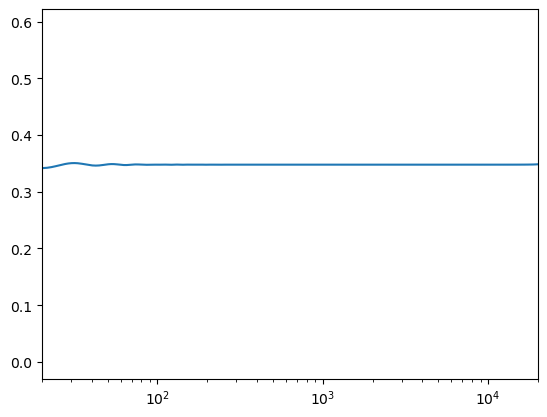

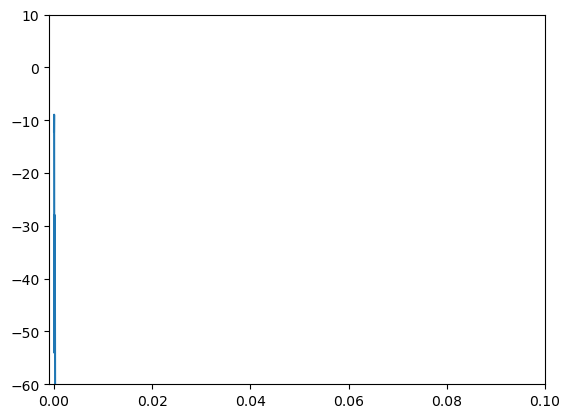

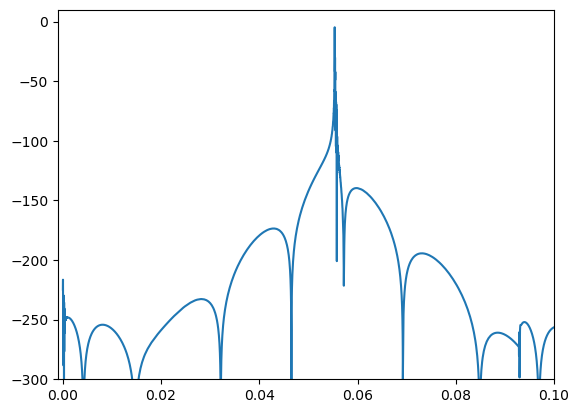

In [52]:
N = 1000000
n_fft = 8192*8
Full_IR =np.zeros(N)
Full_IR[:len(corr_IR)]=corr_IR
Full_IR = loudspeaker.process(Full_IR)





f = np.fft.rfftfreq(n=n_fft, d=1/sr)
df = f[1]-f[0]
plt.plot(f, get_groupDelay(np.fft.rfft(Full_IR, n=n_fft), df=df))
plt.semilogx()
plt.xlim(20, 20000)
plt.show()

t=np.arange(N)/sr
plt.plot(t, dB20(loudspeaker.get_impulseResponse(n=N)))
plt.xlim(-.001, .1)
plt.ylim(-60, 10)
plt.show()

plt.plot(t, dB20(Full_IR))

plt.xlim(-.001, .1)
plt.ylim(-300, 10)
plt.show()

In [ ]:
scipy.io.wavfile.write('gd_correction_44100.wav', rate=sr, data=corr_IR)

In [ ]:
.3*44100